# Model import using the Petab format

In this notebook, we illustrate using pyPESTO together with PEtab and AMICI. We employ models from the benchmark collection, which we first download:

In [1]:
import pypesto
import amici
import petab

import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Download benchmark models - Note: 200MB :(
!git clone --depth 1 https://github.com/LeonardSchmiester/Benchmark-Models.git tmp/benchmark-models || (cd tmp/benchmark-models && git pull)

folder_base = "tmp/benchmark-models/hackathon_contributions_new_data_format/"

fatal: destination path 'tmp/benchmark-models' already exists and is not an empty directory.
Already up to date.


## Manage PEtab model

A PEtab problem comprises all the information on the model, the data and the parameters to perform parameter estimation:

In [2]:
# a collection of models that can be simulated

#model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"
#model_name = "Fujita_SciSignal2010"
#model_name = "Sneyd_PNAS2002"
#model_name = "Borghans_BiophysChem1997"
#model_name = "Elowitz_Nature2000"
#model_name = "Crauste_CellSystems2017"
#model_name = "Lucarelli_CellSystems2018"
#model_name = "Schwen_PONE2014"
#model_name = "Blasi_CellSystems2016"

# the yaml configuration file links to all needed files
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# the petab problem offers various functions
petab_problem.get_optimization_to_simulation_parameter_mapping()

[({},
  {'Epo_degradation_BaF3': 'Epo_degradation_BaF3',
   'k_exp_hetero': 'k_exp_hetero',
   'k_exp_homo': 'k_exp_homo',
   'k_imp_hetero': 'k_imp_hetero',
   'k_imp_homo': 'k_imp_homo',
   'k_phos': 'k_phos',
   'ratio': 0.693,
   'specC17': 0.107,
   'noiseParameter1_rSTAT5A_rel': 'sd_rSTAT5A_rel',
   'noiseParameter1_pSTAT5B_rel': 'sd_pSTAT5B_rel',
   'noiseParameter1_pSTAT5A_rel': 'sd_pSTAT5A_rel'})]

## Import model to AMICI

The model must be imported to AMICI:

In [3]:
importer = pypesto.PetabImporter(petab_problem)

model = importer.create_model()

print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')

Model parameters: ['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'ratio', 'specC17', 'noiseParameter1_rSTAT5A_rel', 'noiseParameter1_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel'] 

Model const parameters: [] 

Model outputs:    ['pSTAT5A_rel', 'pSTAT5B_rel', 'rSTAT5A_rel'] 

Model states:     ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB'] 



## Create objective function

In [7]:
import libsbml
converter_config = libsbml.SBMLLocalParameterConverter()\
    .getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()

# for some models, hyperparamters need to be adjusted
#obj.amici_solver.setMaxSteps(10000)
#obj.amici_solver.setRelativeTolerance(1e-7)
#obj.amici_solver.setAbsoluteTolerance(1e-7)

ret = obj(petab_problem.x_nominal_scaled, sensi_orders=(0,1), return_dict=True)
print(ret)

{'fval': 138.22199669642814, 'grad': array([ 2.20244501e-02,  5.53227488e-02,  5.78815970e-03,  5.38990426e-03,
       -4.51595806e-05,  7.91572700e-03,  0.00000000e+00,  1.07825579e-02,
        2.40394418e-02,  1.91922979e-02,  0.00000000e+00]), 'hess': array([[-2.11105591e+03, -5.89390029e-01, -1.07159928e+02,
        -2.81393959e+03, -8.94333734e-06,  7.86055094e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.89390029e-01, -1.91513742e-03,  1.72774938e-01,
        -7.12558452e-01,  3.69774928e-08,  3.20531694e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.07159928e+02,  1.72774938e-01, -6.99839706e+01,
        -1.61497705e+02, -7.16323527e-06,  8.83572706e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.81393959e+03, -7.12558452e-01, -1.61497705e+02,
        -3.76058323e+03, -

For debugging: There is an alternative way of computing the function, in amici directly.

In [6]:
import libsbml
converter_config = libsbml.SBMLLocalParameterConverter()\
    .getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()

obj.use_amici_petab_simulate = True

# for some models, hyperparamters need to be adjusted
#obj.amici_solver.setMaxSteps(int(1e8))
#obj.amici_solver.setRelativeTolerance(1e-3)
#obj.amici_solver.setAbsoluteTolerance(1e-3)

ret2 = obj(petab_problem.x_nominal_scaled, sensi_orders=(0,1), return_dict=True)
print(ret2)

{'fval': 138.22199677513575, 'grad': array([ 2.20386015e-02,  5.53227506e-02,  5.78886452e-03,  5.40656415e-03,
       -4.51595809e-05,  7.91163446e-03,             nan,  1.07840959e-02,
        2.40378735e-02,  1.91919657e-02,             nan]), 'rdatas': [<amici.numpy.ReturnDataView object at 0x7f18d96d2630>]}


A finite difference check whether the computed gradient is accurate:

In [8]:
problem = importer.create_problem(obj)

objective = problem.objective

ret = objective(petab_problem.x_nominal_free_scaled, sensi_orders=(0,1))
print(ret)

(138.22199669642814, array([ 2.20244501e-02,  5.53227488e-02,  5.78815970e-03,  5.38990426e-03,
       -4.51595806e-05,  7.91572700e-03,  1.07825579e-02,  2.40394418e-02,
        1.91922979e-02]))


In [9]:
eps = 1e-4

def fd(x):
    grad = np.zeros_like(x)
    j = 0
    for i, xi in enumerate(x):
        mask = np.zeros_like(x)
        mask[i] += eps
        valinc, _ = objective(x+mask, sensi_orders=(0,1))
        valdec, _ = objective(x-mask, sensi_orders=(0,1))
        grad[j] = (valinc - valdec) / (2*eps)
        j += 1
    return grad

fdval = fd(petab_problem.x_nominal_free_scaled)
print("fd: ", fdval)
print("l2 difference: ", np.linalg.norm(ret[1] - fdval))

fd:  [0.02263562 0.05690482 0.00881361 0.01296013 0.00300339 0.00106886
 0.01078126 0.02403814 0.019191  ]
l2 difference:  0.011203180836396714


## Run optimization

In [10]:
print(problem.x_fixed_indices, problem.x_free_indices)

[6, 10] [0, 1, 2, 3, 4, 5, 7, 8, 9]


In [11]:
optimizer = pypesto.ScipyOptimizer()

engine = pypesto.SingleCoreEngine()
engine = pypesto.MultiProcessEngine()

# do the optimization
result = pypesto.minimize(problem=problem, optimizer=optimizer,
                          n_starts=10, engine=engine)

Engine set up to use up to 4 processes in total. The number was automatically determined and might not be appropriate on some systems.
[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 159.483 and h = 4.33228e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 159.483129:
AMICI failed to integrate the forward problem

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 159.483 and h = 4.33228e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 159.483129:
AMICI failed to integrate the forward problem

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 159.483 and h = 4.33228e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward s

## Visualize

In [12]:
result.optimize_result.get_for_key('fval')

[147.543964168735,
 149.5881009601435,
 154.1622062025383,
 156.34143276344116,
 158.80984883881163,
 164.4256707463913,
 246.34134662028166,
 249.745997443242,
 249.7459974432567,
 249.74600498692047]

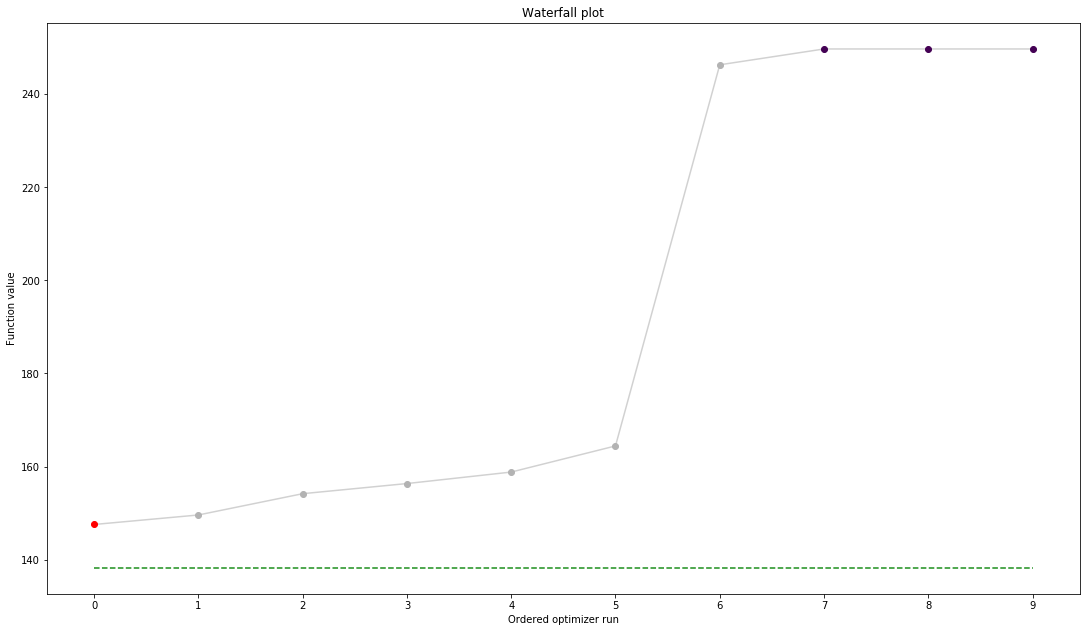

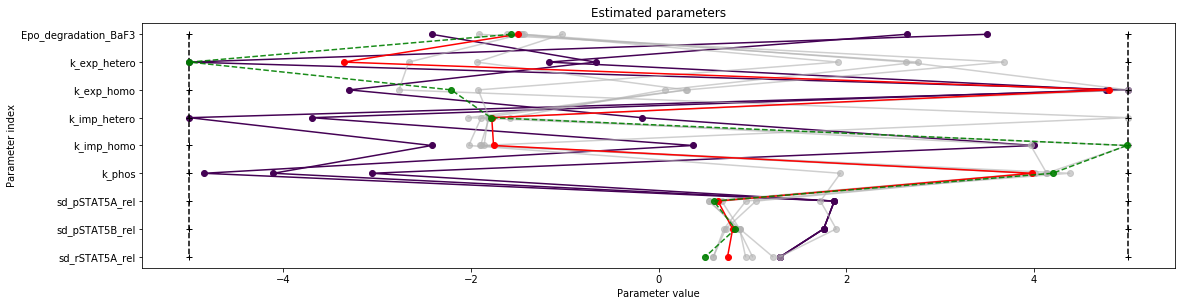

In [13]:
import pypesto.visualize

ref = pypesto.visualize.create_references(x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled))

pypesto.visualize.waterfall(result, reference=ref, scale_y='lin')
pypesto.visualize.parameters(result, reference=ref)